# **스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 target을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 다음의 두가지 방법 중 하나를 선택하여 폴더를 준비하고 데이터를 로딩하시오.
        * 1) 로컬 수행(Ananconda)
            * 제공된 압축파일을 다운받아 압축을 풀고
            * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
        * 2) 구글콜랩
            * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
            * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다. 
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [1]:
# path = 'C:/Users/User/Desktop/'
path = 'C:/Users/wl/Desktop/본수업 시작/미니프로젝트/3차 - 240404/1일차/'

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# path = '/content/drive/MyDrive/project/'

### (2) 라이브러리 설치 및 불러오기

1) 라이브러리 로딩

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#필요하다고 판단되는 라이브러리를 추가하세요.

#### 3) 제공 함수 생성
* 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
* 입력 : 
    * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
    * names : 변수 이름 목록(예 : x_train.columns
    * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
    * topn : 중요도 상위 n개만 표시. all 이면 전체.
* 출력 : 
    * 중요도 그래프 : 중요도 내림차순으로 정렬
    * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [5]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,5))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [6]:
df_train = pd.read_csv(path +'data01_train.csv')
df_test = pd.read_csv(path +'data01_test.csv')
df_feature = pd.read_csv(path +'features.csv')
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [7]:
df_test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,22,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,15,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,22,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,8,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,5,STANDING


In [8]:
df_feature

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y
...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)"
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)"
558,angle,X,gravityMean,"angle(X,gravityMean)"
559,angle,Y,gravityMean,"angle(Y,gravityMean)"


In [9]:
# subject 삭제
df_train.drop('subject', axis=1, inplace=True)
df_test.drop('subject', axis=1, inplace=True)
df_train.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [10]:
df_test.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [11]:
df_train.shape

(5881, 562)

In [12]:
df_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [13]:
# df_train.iloc[:,101:201].info()
# df_train.iloc[:,201:301].info()
# df_train.iloc[:,301:401].info()
# df_train.iloc[:,401:501].info()
df_train.iloc[:,501:563].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Data columns (total 61 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   fBodyGyro-bandsEnergy()-25,48.2       5881 non-null   float64
 1   fBodyAccMag-mean()                    5881 non-null   float64
 2   fBodyAccMag-std()                     5881 non-null   float64
 3   fBodyAccMag-mad()                     5881 non-null   float64
 4   fBodyAccMag-max()                     5881 non-null   float64
 5   fBodyAccMag-min()                     5881 non-null   float64
 6   fBodyAccMag-sma()                     5881 non-null   float64
 7   fBodyAccMag-energy()                  5881 non-null   float64
 8   fBodyAccMag-iqr()                     5881 non-null   float64
 9   fBodyAccMag-entropy()                 5881 non-null   float64
 10  fBodyAccMag-maxInds                   5881 non-null   float64
 11  fBodyAccMag-meanF

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [14]:
df_train['Activity'].values

array(['STANDING', 'LAYING', 'STANDING', ..., 'LAYING',
       'WALKING_UPSTAIRS', 'SITTING'], dtype=object)

In [15]:
df_train['Activity'].value_counts() / 5881 *100
# (normalize=True)

LAYING                18.959361
STANDING              18.483251
SITTING               17.548036
WALKING               16.969903
WALKING_UPSTAIRS      14.589356
WALKING_DOWNSTAIRS    13.450094
Name: Activity, dtype: float64

In [16]:
# 시각화 ##

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [17]:
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [18]:
# 센서1 Acc 가속도
columns_with_tBodyAcc = [col for col in df_train.columns if 'tBodyAcc' in col]
len(columns_with_tBodyAcc)

108

In [19]:
# 센서2 Gyro 각속도
columns_with_tBodyAcc = [col for col in df_train.columns if 'tBodyGyro' in col]
len(columns_with_tBodyAcc)

108

In [20]:
df_train.shape

(5881, 562)

## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다. 
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [21]:
df_train['Activity']

0                 STANDING
1                   LAYING
2                 STANDING
3                  WALKING
4       WALKING_DOWNSTAIRS
               ...        
5876               SITTING
5877      WALKING_UPSTAIRS
5878                LAYING
5879      WALKING_UPSTAIRS
5880               SITTING
Name: Activity, Length: 5881, dtype: object

In [22]:
x = df_train.drop('Activity', axis=1)
y = df_train['Activity']

# x = pd.get_dummies(df_train, 'Activity', drop_first=True, dtype=int)
# x.head()

In [23]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=1)

#### 2) 모델링

In [24]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(x_train, y_train)
# model.predict(x_train, y_train)

RandomForestClassifier()

#### 3) 변수 중요도 추출

In [25]:
df = pd.DataFrame()
df['feature'] = list(x)
df['Importances'] = model.feature_importances_
df.sort_values(by = 'Importances', ascending=False, inplace=True)
df[:5]

# plt.figure(figsize=(6, 8))
# plt.barh(df['feature'], df['Importances'])
# plt.show()

,feature,Importances
52,tGravityAcc-min()-X,0.044952
558,"angle(X,gravityMean)",0.044243
40,tGravityAcc-mean()-X,0.033507
50,tGravityAcc-max()-Y,0.026291
41,tGravityAcc-mean()-Y,0.025577


,feature_name,feature_importance
0,tGravityAcc-min()-X,0.044952
1,"angle(X,gravityMean)",0.044243
2,tGravityAcc-mean()-X,0.033507
3,tGravityAcc-max()-Y,0.026291
4,tGravityAcc-mean()-Y,0.025577


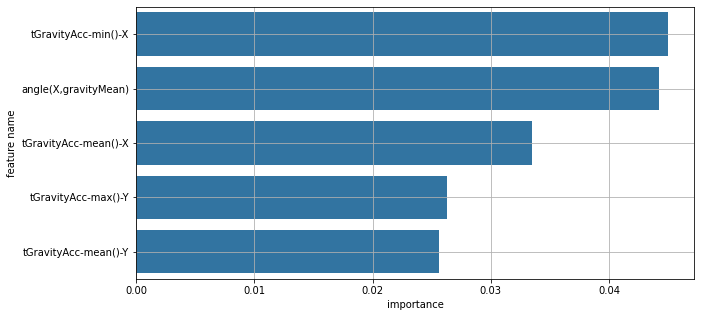

In [26]:
plot_feature_importance(model.feature_importances_, x_train.columns, topn=5)

In [27]:
# 저장
df.to_csv('df_feature_imp.csv', index=False)
df_feature_imp=pd.read_csv('df_feature_imp.csv')
df_feature_imp

,feature,Importances
0,tGravityAcc-min()-X,0.044952
1,"angle(X,gravityMean)",0.044243
2,tGravityAcc-mean()-X,0.033507
3,tGravityAcc-max()-Y,0.026291
4,tGravityAcc-mean()-Y,0.025577
...,...,...
556,"fBodyAcc-bandsEnergy()-41,48",0.000072
557,"fBodyAccJerk-bandsEnergy()-57,64",0.000071
558,"fBodyGyro-bandsEnergy()-49,56.2",0.000069
559,fBodyBodyGyroJerkMag-min(),0.000064


### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [28]:
df.sort_values(by = 'Importances', ascending=True, inplace=True)
display(df[:5])
display(df.iloc[:5,0])

,feature,Importances
406,"fBodyAccJerk-bandsEnergy()-49,64.1",0.000056
545,fBodyBodyGyroJerkMag-min(),0.000064
494,"fBodyGyro-bandsEnergy()-49,56.2",0.000069
388,"fBodyAccJerk-bandsEnergy()-57,64",0.000071
307,"fBodyAcc-bandsEnergy()-41,48",0.000072


406    fBodyAccJerk-bandsEnergy()-49,64.1
545            fBodyBodyGyroJerkMag-min()
494       fBodyGyro-bandsEnergy()-49,56.2
388      fBodyAccJerk-bandsEnergy()-57,64
307          fBodyAcc-bandsEnergy()-41,48
Name: feature, dtype: object

In [29]:
# 하위 5개
list(df.iloc[:5,0])

['fBodyAccJerk-bandsEnergy()-49,64.1',
 'fBodyBodyGyroJerkMag-min()',
 'fBodyGyro-bandsEnergy()-49,56.2',
 'fBodyAccJerk-bandsEnergy()-57,64',
 'fBodyAcc-bandsEnergy()-41,48']

In [30]:
df = pd.DataFrame()
df['feature'] = list(x)
df['Importances'] = model.feature_importances_
df.sort_values(by = 'Importances', ascending=False, inplace=True)
display(df[:5])
display(df.iloc[:5,0])

,feature,Importances
52,tGravityAcc-min()-X,0.044952
558,"angle(X,gravityMean)",0.044243
40,tGravityAcc-mean()-X,0.033507
50,tGravityAcc-max()-Y,0.026291
41,tGravityAcc-mean()-Y,0.025577


52      tGravityAcc-min()-X
558    angle(X,gravityMean)
40     tGravityAcc-mean()-X
50      tGravityAcc-max()-Y
41     tGravityAcc-mean()-Y
Name: feature, dtype: object

In [31]:
# 상위 5개
list(df.iloc[:5,0])

['tGravityAcc-min()-X',
 'angle(X,gravityMean)',
 'tGravityAcc-mean()-X',
 'tGravityAcc-max()-Y',
 'tGravityAcc-mean()-Y']

#### 2) 상위 5개 변수에 대한 분석

In [32]:
y.value_counts()

LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64

In [33]:
# 범주형변환, 숫자로 변환
df_train_tmp = df_train.copy()
df_train_tmp['Activity']=pd.Categorical(df_train_tmp['Activity'])
df_train_tmp['Activity']=df_train_tmp['Activity'].cat.codes
df_train_tmp['Activity']

In [34]:
cols = ['Activity',
 'angle(X,gravityMean)',
 'tGravityAcc-energy()-X',
 'angle(Y,gravityMean)',
 'tGravityAcc-min()-X',
 'tGravityAcc-mean()-Y']

<AxesSubplot:xlabel='angle(X,gravityMean)', ylabel='Density'>

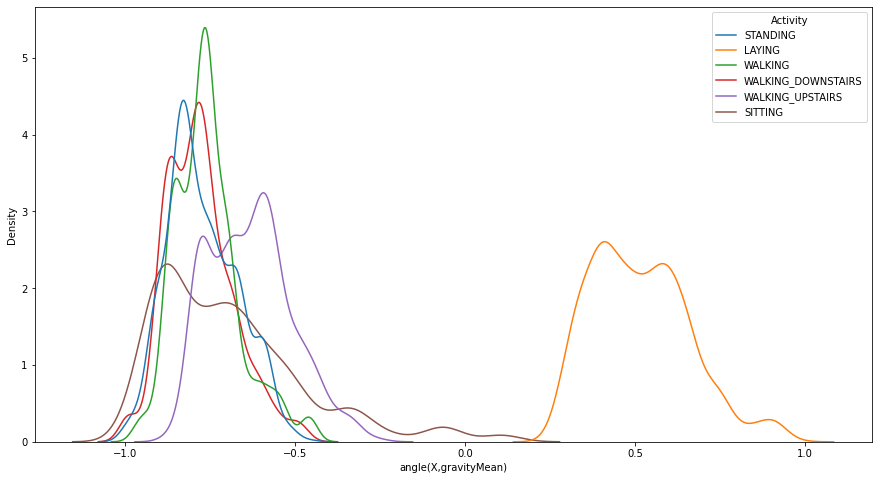

In [38]:
# 다시작업
cols = [ 'angle(X,gravityMean)',
 'tGravityAcc-energy()-X',
 'angle(Y,gravityMean)',
 'tGravityAcc-min()-X',
 'tGravityAcc-mean()-Y']

# 1위 : angle(X,gravityMean)
var = 'angle(X,gravityMean)'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = df_train, hue ='Activity', common_norm = False)

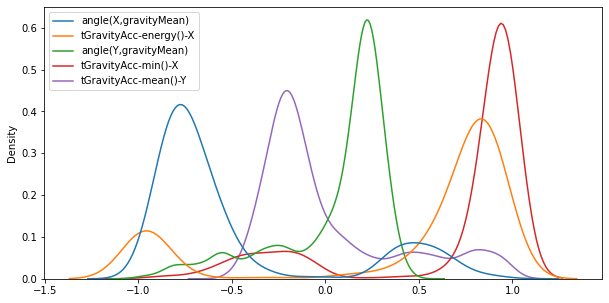

In [37]:
import seaborn as sns ## standing, raying
plt.figure(figsize=(10,5))
sns.kdeplot(df_train_tmp[cols])
plt.show()

In [ ]:
#############################################

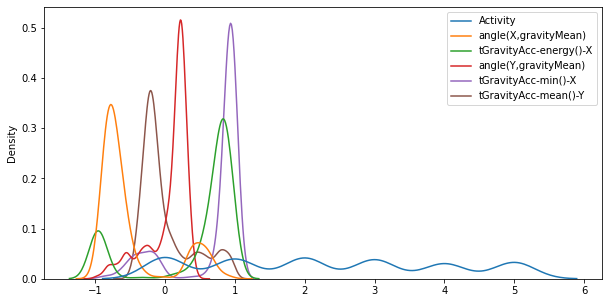

In [1529]:
import seaborn as sns ## standing, raying
plt.figure(figsize=(10,5))
sns.kdeplot(df_train_tmp[cols])
plt.show()

#### 3) 하위 5개 변수에 대한 분석

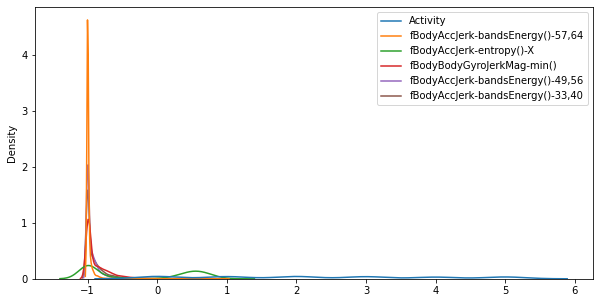

In [1530]:
cols = ['Activity',
 'fBodyAccJerk-bandsEnergy()-57,64',
 'fBodyAccJerk-entropy()-X',
 'fBodyBodyGyroJerkMag-min()',
 'fBodyAccJerk-bandsEnergy()-49,56',
 'fBodyAccJerk-bandsEnergy()-33,40']

plt.figure(figsize=(10,5))
sns.kdeplot(df_train_tmp[cols])
plt.show()

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오. 


#### 1) 결과 merge

In [1531]:
df_feature_imp=pd.read_csv('df_feature_imp.csv')
df_feature_imp

,feature,Importances
0,"angle(Y,gravityMean)",0.033649
1,tGravityAcc-mean()-Y,0.032202
2,tGravityAcc-energy()-X,0.031844
3,tGravityAcc-min()-X,0.030369
4,tGravityAcc-max()-Y,0.026364
...,...,...
556,"tBodyAccJerk-arCoeff()-X,2",0.000095
557,fBodyGyro-min()-Y,0.000087
558,fBodyAcc-maxInds-Z,0.000072
559,tBodyAccJerk-mean()-Z,0.000067


In [1532]:
df_feature

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y
...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)"
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)"
558,angle,X,gravityMean,"angle(X,gravityMean)"
559,angle,Y,gravityMean,"angle(Y,gravityMean)"


In [1533]:
df2 = pd.merge(df_feature_imp, df_feature, left_on='feature', right_on='feature_name', how='inner')
df2

,feature,Importances,sensor,agg,axis,feature_name
0,"angle(Y,gravityMean)",0.033649,angle,Y,gravityMean,"angle(Y,gravityMean)"
1,tGravityAcc-mean()-Y,0.032202,tGravityAcc,mean(),Y,tGravityAcc-mean()-Y
2,tGravityAcc-energy()-X,0.031844,tGravityAcc,energy(),X,tGravityAcc-energy()-X
3,tGravityAcc-min()-X,0.030369,tGravityAcc,min(),X,tGravityAcc-min()-X
4,tGravityAcc-max()-Y,0.026364,tGravityAcc,max(),Y,tGravityAcc-max()-Y
...,...,...,...,...,...,...
556,"tBodyAccJerk-arCoeff()-X,2",0.000095,tBodyAccJerk,arCoeff(),"X,2","tBodyAccJerk-arCoeff()-X,2"
557,fBodyGyro-min()-Y,0.000087,fBodyGyro,min(),Y,fBodyGyro-min()-Y
558,fBodyAcc-maxInds-Z,0.000072,fBodyAcc,maxInds,Z,fBodyAcc-maxInds-Z
559,tBodyAccJerk-mean()-Z,0.000067,tBodyAccJerk,mean(),Z,tBodyAccJerk-mean()-Z


In [1534]:
df2.columns

Index(['feature', 'Importances', 'sensor', 'agg', 'axis', 'feature_name'], dtype='object')

In [1535]:
df2.drop(['feature_name'], axis=1, inplace=True)
df2.columns

Index(['feature', 'Importances', 'sensor', 'agg', 'axis'], dtype='object')

In [1536]:
df2.head()

,feature,Importances,sensor,agg,axis
0,"angle(Y,gravityMean)",0.033649,angle,Y,gravityMean
1,tGravityAcc-mean()-Y,0.032202,tGravityAcc,mean(),Y
2,tGravityAcc-energy()-X,0.031844,tGravityAcc,energy(),X
3,tGravityAcc-min()-X,0.030369,tGravityAcc,min(),X
4,tGravityAcc-max()-Y,0.026364,tGravityAcc,max(),Y


#### 2) sensor 별 중요도

In [1537]:
df2.groupby('sensor')[['Importances']].sum() # as_index=False #!

,Importances
sensor,
angle,0.067466
fBodyAcc,0.085341
fBodyAccJerk,0.108228
fBodyAccMag,0.041605
fBodyBodyAccJerkMag,0.010693
fBodyBodyGyroJerkMag,0.003966
fBodyBodyGyroMag,0.004152
fBodyGyro,0.075964
tBodyAcc,0.055817


In [1538]:
# sensor 별 중요도 합계
sorted_df = df2.groupby('sensor')[['Importances']].sum().sort_values(by='Importances', ascending=False)
sorted_df

,Importances
sensor,
tGravityAcc,0.336245
fBodyAccJerk,0.108228
fBodyAcc,0.085341
fBodyGyro,0.075964
angle,0.067466
tBodyAcc,0.055817
tBodyAccJerk,0.055144
tBodyAccJerkMag,0.043117
fBodyAccMag,0.041605


In [1539]:
# 상위 변수 그룹별 비교 분석
sorted_df[:10]

,Importances
sensor,
tGravityAcc,0.336245
fBodyAccJerk,0.108228
fBodyAcc,0.085341
fBodyGyro,0.075964
angle,0.067466
tBodyAcc,0.055817
tBodyAccJerk,0.055144
tBodyAccJerkMag,0.043117
fBodyAccMag,0.041605


#### 3) sensor + agg 별 중요도

In [1540]:
# sensor+agge별 중요도 합계
sorted_df = df2.groupby(['sensor','agg'])[['Importances']].sum().sort_values(by='Importances', ascending=False)
sorted_df[:10]

Importances
sensor       agg                       
tGravityAcc  arCoeff()         0.070168
             min()             0.062689
             max()             0.062469
             mean()            0.059357
             energy()          0.052677
fBodyAccJerk bandsEnergy()     0.048108
fBodyGyro    bandsEnergy()     0.039568
fBodyAcc     bandsEnergy()     0.036073
angle        Y                 0.033649
             X                 0.024073

## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [1541]:
df_train['Activity'].value_counts()

LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64

#### 1) is_dynamic 추가

In [1542]:
df_train['is_dynamic'] = df_train['Activity'].replace({'STANDING': 0, 'SITTING': 0, 'LAYING': 0, 'WALKING': 1, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 1})
df_train['is_dynamic'].value_counts()

0    3234
1    2647
Name: is_dynamic, dtype: int64

In [1543]:
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


#### 2) 기본모델 생성

In [1544]:
x.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.032207,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.246705,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.388765,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.050888,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.013902,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758


In [1545]:
y = df_train['is_dynamic']

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=1)


from sklearn.ensemble import RandomForestClassifier
model4 = RandomForestClassifier()
model4.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
#! confusion_matrix

#### 3) 변수중요도 상위 5개 분석

In [1546]:
df4 = pd.DataFrame()
df4['feature'] = list(x)
df4['Importances'] = model4.feature_importances_
df4.sort_values(by = 'Importances', ascending=False, inplace=True)
df4[:5]

,feature,Importances
347,fBodyAccJerk-std()-X,0.050118
86,tBodyAccJerk-mad()-X,0.050069
231,tBodyAccJerkMag-sma(),0.039949
226,tBodyAccJerkMag-mean(),0.039908
95,tBodyAccJerk-sma(),0.039901


* 상위 변수 선정

In [1547]:
cols=list(df4.iloc[:5,:1]['feature'])
cols

['fBodyAccJerk-std()-X',
 'tBodyAccJerk-mad()-X',
 'tBodyAccJerkMag-sma()',
 'tBodyAccJerkMag-mean()',
 'tBodyAccJerk-sma()']

* 데이터 탐색하기

,feature_name,feature_importance
0,fBodyAccJerk-std()-X,0.050118
1,tBodyAccJerk-mad()-X,0.050069
2,tBodyAccJerkMag-sma(),0.039949
3,tBodyAccJerkMag-mean(),0.039908
4,tBodyAccJerk-sma(),0.039901


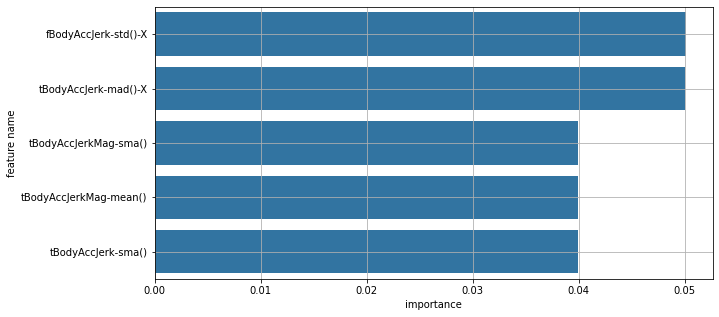

In [1548]:
plot_feature_importance(model4.feature_importances_, x_train.columns, topn=5)

In [1549]:
df4.to_csv('df_feature_imp4.csv',index=False)
df_feature_imp4=pd.read_csv('df_feature_imp4.csv')
df_feature_imp4

,feature,Importances
0,fBodyAccJerk-std()-X,0.050118
1,tBodyAccJerk-mad()-X,0.050069
2,tBodyAccJerkMag-sma(),0.039949
3,tBodyAccJerkMag-mean(),0.039908
4,tBodyAccJerk-sma(),0.039901
...,...,...
556,tBodyAccMag-iqr(),0.000000
557,tBodyAccMag-energy(),0.000000
558,tBodyAccMag-sma(),0.000000
559,tBodyAccMag-min(),0.000000


#### 4) feature 그룹별 분석

* 결과 merge

In [1550]:
df_feature_imp4.head()

C:\Users\wl\anaconda3\lib\site-packages\IPython\core\displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,feature,Importances
0,fBodyAccJerk-std()-X,0.050118
1,tBodyAccJerk-mad()-X,0.050069
2,tBodyAccJerkMag-sma(),0.039949
3,tBodyAccJerkMag-mean(),0.039908
4,tBodyAccJerk-sma(),0.039901


In [1551]:
df_feature.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


In [1552]:
df4 = pd.merge(df_feature_imp4, df_feature, left_on='feature', right_on='feature_name', how='inner')
df4.head()

,feature,Importances,sensor,agg,axis,feature_name
0,fBodyAccJerk-std()-X,0.050118,fBodyAccJerk,std(),X,fBodyAccJerk-std()-X
1,tBodyAccJerk-mad()-X,0.050069,tBodyAccJerk,mad(),X,tBodyAccJerk-mad()-X
2,tBodyAccJerkMag-sma(),0.039949,tBodyAccJerkMag,sma(),NaN,tBodyAccJerkMag-sma()
3,tBodyAccJerkMag-mean(),0.039908,tBodyAccJerkMag,mean(),NaN,tBodyAccJerkMag-mean()
4,tBodyAccJerk-sma(),0.039901,tBodyAccJerk,sma(),NaN,tBodyAccJerk-sma()


In [1553]:
df4.drop(['feature_name'], axis=1, inplace=True)
df4.head()

,feature,Importances,sensor,agg,axis
0,fBodyAccJerk-std()-X,0.050118,fBodyAccJerk,std(),X
1,tBodyAccJerk-mad()-X,0.050069,tBodyAccJerk,mad(),X
2,tBodyAccJerkMag-sma(),0.039949,tBodyAccJerkMag,sma(),NaN
3,tBodyAccJerkMag-mean(),0.039908,tBodyAccJerkMag,mean(),NaN
4,tBodyAccJerk-sma(),0.039901,tBodyAccJerk,sma(),NaN


* sensor 별 중요도

In [1554]:
# sensor 별 중요도 합계
sorted_df = df4.groupby('sensor')[['Importances']].sum().sort_values(by='Importances', ascending=False)

# 상위 변수 그룹별 비교 분석
sorted_df[:10]

,Importances
sensor,
fBodyAccJerk,0.370157
tBodyAccJerk,0.269124
tBodyAccJerkMag,0.149483
fBodyAcc,0.070253
tBodyGyroJerk,0.069829
fBodyGyro,0.030297
fBodyBodyAccJerkMag,0.029794
tBodyAcc,0.010219
tGravityAcc,0.000281


In [1555]:
df4['agg']

0         std()
1         mad()
2         sma()
3        mean()
4         sma()
         ...   
556       iqr()
557    energy()
558       sma()
559       min()
560           Z
Name: agg, Length: 561, dtype: object

* sensor + agg 별 중요도

In [1556]:
# sensor+agge별 중요도 합계
sorted_df = df4.groupby(['sensor','agg'])[['Importances']].sum().sort_values(by='Importances', ascending=False)
sorted_df[:10]

Importances
sensor          agg                       
fBodyAccJerk    bandsEnergy()     0.159808
                std()             0.070039
tBodyAccJerk    mad()             0.069941
tBodyAccJerkMag sma()             0.039949
                mean()            0.039908
tBodyAccJerk    sma()             0.039901
                iqr()             0.039882
                energy()          0.039834
                entropy()         0.039735
fBodyAccJerk    energy()          0.030010

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_standing 추가

In [1557]:
df_train['Activity'].value_counts()

LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64

In [1558]:
df_train['is_standing'] = df_train['Activity'].replace({'STANDING': 1, 'SITTING': 0, 'LAYING': 0, 'WALKING': 0, 'WALKING_UPSTAIRS': 0, 'WALKING_DOWNSTAIRS': 0})
df_train['is_standing'].value_counts()

0    4794
1    1087
Name: is_standing, dtype: int64

In [1559]:
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic,is_standing
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0,1
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0,1
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1,0


#### 2) 기본모델 생성

In [1560]:
y = df_train['is_standing']

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=1)


from sklearn.ensemble import RandomForestClassifier
model5 = RandomForestClassifier()
model5.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
##! 예측

#### 3) 변수중요도 상위 5개 분석

In [1561]:
df5 = pd.DataFrame()
df5['feature'] = list(x)
df5['Importances'] = model5.feature_importances_
df5.sort_values(by = 'Importances', ascending=False, inplace=True)
df5[:5]

,feature,Importances
50,tGravityAcc-max()-Y,0.072774
559,"angle(Y,gravityMean)",0.055339
41,tGravityAcc-mean()-Y,0.046584
53,tGravityAcc-min()-Y,0.044075
560,"angle(Z,gravityMean)",0.034902


* 상위 변수 선정

In [1562]:
cols=list(df5.iloc[:5,:1]['feature'])
cols

['tGravityAcc-max()-Y',
 'angle(Y,gravityMean)',
 'tGravityAcc-mean()-Y',
 'tGravityAcc-min()-Y',
 'angle(Z,gravityMean)']

* 데이터 탐색하기

,feature_name,feature_importance
0,tGravityAcc-max()-Y,0.072774
1,"angle(Y,gravityMean)",0.055339
2,tGravityAcc-mean()-Y,0.046584
3,tGravityAcc-min()-Y,0.044075
4,"angle(Z,gravityMean)",0.034902


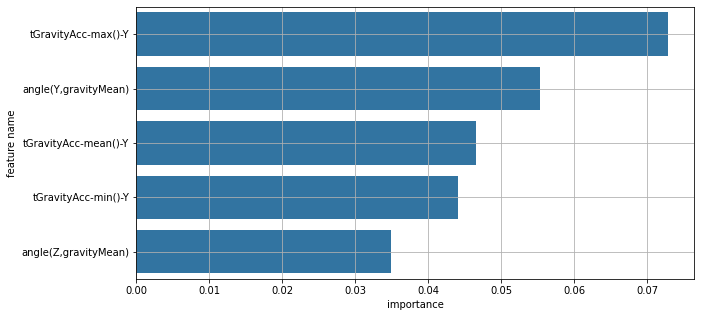

In [1563]:
plot_feature_importance(model5.feature_importances_, x_train.columns, topn=5)

In [1564]:
df5.to_csv('df_feature_imp5.csv',index=False)
df_feature_imp5=pd.read_csv('df_feature_imp5.csv')
df_feature_imp5

,feature,Importances
0,tGravityAcc-max()-Y,0.072774
1,"angle(Y,gravityMean)",0.055339
2,tGravityAcc-mean()-Y,0.046584
3,tGravityAcc-min()-Y,0.044075
4,"angle(Z,gravityMean)",0.034902
...,...,...
556,tBodyGyro-mad()-Z,0.000067
557,tGravityAccMag-energy(),0.000059
558,fBodyBodyAccJerkMag-mean(),0.000055
559,fBodyAccJerk-entropy()-X,0.000053


#### 4) feature 그룹별 분석

* 결과 merge

In [1565]:
df_feature_imp5.head()
df_feature.head()
df5 = pd.merge(df_feature_imp5, df_feature, left_on='feature', right_on='feature_name', how='inner')
df5.head()

,feature,Importances,sensor,agg,axis,feature_name
0,tGravityAcc-max()-Y,0.072774,tGravityAcc,max(),Y,tGravityAcc-max()-Y
1,"angle(Y,gravityMean)",0.055339,angle,Y,gravityMean,"angle(Y,gravityMean)"
2,tGravityAcc-mean()-Y,0.046584,tGravityAcc,mean(),Y,tGravityAcc-mean()-Y
3,tGravityAcc-min()-Y,0.044075,tGravityAcc,min(),Y,tGravityAcc-min()-Y
4,"angle(Z,gravityMean)",0.034902,angle,Z,gravityMean,"angle(Z,gravityMean)"


In [1566]:
df5.drop(['feature_name'], axis=1, inplace=True)
df5.head()

,feature,Importances,sensor,agg,axis
0,tGravityAcc-max()-Y,0.072774,tGravityAcc,max(),Y
1,"angle(Y,gravityMean)",0.055339,angle,Y,gravityMean
2,tGravityAcc-mean()-Y,0.046584,tGravityAcc,mean(),Y
3,tGravityAcc-min()-Y,0.044075,tGravityAcc,min(),Y
4,"angle(Z,gravityMean)",0.034902,angle,Z,gravityMean


* sensor 별 중요도

In [1567]:
# sensor 별 중요도 합계
sorted_df = df5.groupby('sensor')[['Importances']].sum().sort_values(by='Importances', ascending=False)

# 상위 변수 그룹별 비교 분석
sorted_df[:10]

,Importances
sensor,
tGravityAcc,0.380548
fBodyGyro,0.107928
angle,0.107700
fBodyAcc,0.107423
tBodyAcc,0.072694
tBodyGyro,0.057998
tBodyGyroJerk,0.042003
fBodyAccJerk,0.031262
tGravityAccMag,0.027227


* sensor + agg 별 중요도

In [1568]:
# sensor+agge별 중요도 합계
sorted_df = df5.groupby(['sensor','agg'])[['Importances']].sum().sort_values(by='Importances', ascending=False)
sorted_df[:10]

Importances
sensor      agg                       
tGravityAcc max()             0.105810
            mean()            0.089072
            min()             0.079158
fBodyGyro   bandsEnergy()     0.061987
angle       Y                 0.055339
tGravityAcc energy()          0.048846
fBodyAcc    bandsEnergy()     0.038614
angle       Z                 0.034902
fBodyAcc    max()             0.018396
tGravityAcc entropy()         0.017225

### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_sitting 추가

In [1569]:
df_train['Activity'].value_counts()

df_train['is_sitting'] = df_train['Activity'].replace({'STANDING': 0, 'SITTING': 1, 'LAYING': 0, 'WALKING': 0, 'WALKING_UPSTAIRS': 0, 'WALKING_DOWNSTAIRS': 0})
df_train['is_sitting'].value_counts()

df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic,is_standing,is_sitting
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0,1,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0,1,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1,0,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1,0,0


#### 2) 기본모델 생성

In [1570]:
## x에서 파생변수 지우기 안해도됨 x 사용해서 train_test_split
y = df_train['is_sitting']

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=1)


from sklearn.ensemble import RandomForestClassifier
model6 = RandomForestClassifier()
model6.fit(x_train, y_train)

RandomForestClassifier()

#### 3) 변수중요도 상위 5개 분석

In [1571]:
df6 = pd.DataFrame()
df6['feature'] = list(x)
df6['Importances'] = model6.feature_importances_
df6.sort_values(by = 'Importances', ascending=False, inplace=True)
df6[:5]

,feature,Importances
53,tGravityAcc-min()-Y,0.049391
559,"angle(Y,gravityMean)",0.037815
41,tGravityAcc-mean()-Y,0.036514
50,tGravityAcc-max()-Y,0.033621
56,tGravityAcc-energy()-X,0.031410


* 상위 변수 선정

In [1572]:
cols=list(df6.iloc[:5,:1]['feature'])
cols

['tGravityAcc-min()-Y',
 'angle(Y,gravityMean)',
 'tGravityAcc-mean()-Y',
 'tGravityAcc-max()-Y',
 'tGravityAcc-energy()-X']

* 데이터 탐색하기

,feature_name,feature_importance
0,tGravityAcc-min()-Y,0.049391
1,"angle(Y,gravityMean)",0.037815
2,tGravityAcc-mean()-Y,0.036514
3,tGravityAcc-max()-Y,0.033621
4,tGravityAcc-energy()-X,0.031410


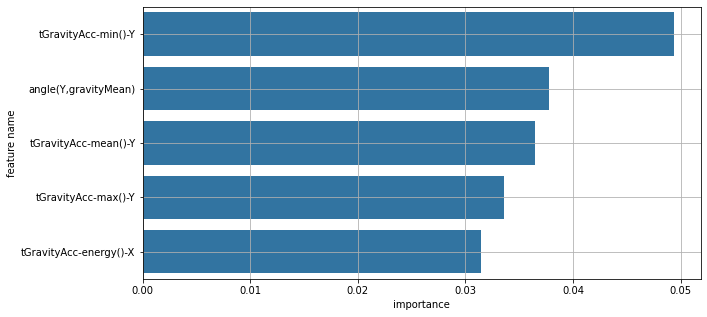

In [1573]:
plot_feature_importance(model6.feature_importances_, x_train.columns, topn=5)

In [1574]:
df6.to_csv('df_feature_imp6.csv',index=False)
df_feature_imp6=pd.read_csv('df_feature_imp6.csv')
df_feature_imp6

,feature,Importances
0,tGravityAcc-min()-Y,0.049391
1,"angle(Y,gravityMean)",0.037815
2,tGravityAcc-mean()-Y,0.036514
3,tGravityAcc-max()-Y,0.033621
4,tGravityAcc-energy()-X,0.031410
...,...,...
556,fBodyBodyAccJerkMag-maxInds,0.000081
557,"fBodyAccJerk-bandsEnergy()-33,48.1",0.000073
558,tBodyAccMag-mad(),0.000071
559,fBodyAccJerk-entropy()-Y,0.000063


#### 4) feature 그룹별 분석

* 결과 merge

In [1575]:
df_feature_imp6.head()
df_feature.head()
df6 = pd.merge(df_feature_imp6, df_feature, left_on='feature', right_on='feature_name', how='inner')
df6.head()

,feature,Importances,sensor,agg,axis,feature_name
0,tGravityAcc-min()-Y,0.049391,tGravityAcc,min(),Y,tGravityAcc-min()-Y
1,"angle(Y,gravityMean)",0.037815,angle,Y,gravityMean,"angle(Y,gravityMean)"
2,tGravityAcc-mean()-Y,0.036514,tGravityAcc,mean(),Y,tGravityAcc-mean()-Y
3,tGravityAcc-max()-Y,0.033621,tGravityAcc,max(),Y,tGravityAcc-max()-Y
4,tGravityAcc-energy()-X,0.031410,tGravityAcc,energy(),X,tGravityAcc-energy()-X


In [1576]:
df6.drop(['feature_name'], axis=1, inplace=True)
df6.head()

,feature,Importances,sensor,agg,axis
0,tGravityAcc-min()-Y,0.049391,tGravityAcc,min(),Y
1,"angle(Y,gravityMean)",0.037815,angle,Y,gravityMean
2,tGravityAcc-mean()-Y,0.036514,tGravityAcc,mean(),Y
3,tGravityAcc-max()-Y,0.033621,tGravityAcc,max(),Y
4,tGravityAcc-energy()-X,0.031410,tGravityAcc,energy(),X


* sensor 별 중요도

In [1577]:
# sensor 별 중요도 합계
sorted_df = df6.groupby('sensor')[['Importances']].sum().sort_values(by='Importances', ascending=False)

# 상위 변수 그룹별 비교 분석
sorted_df[:10]

,Importances
sensor,
tGravityAcc,0.335776
fBodyGyro,0.268756
tBodyGyro,0.090322
angle,0.085430
tBodyGyroJerk,0.079439
fBodyAccJerk,0.063640
fBodyAcc,0.044904
tBodyAcc,0.033367
tBodyAccJerk,0.023524


* sensor + agg 별 중요도

In [1578]:
# sensor+agg별 중요도 합계
sorted_df = df6.groupby(['sensor','agg'])[['Importances']].sum().sort_values(by='Importances', ascending=False)
sorted_df[:10]

Importances
sensor       agg                       
fBodyGyro    bandsEnergy()     0.173465
tGravityAcc  min()             0.084460
             mean()            0.075956
             max()             0.071000
             energy()          0.060240
fBodyAccJerk bandsEnergy()     0.042441
angle        Y                 0.037815
             X                 0.030849
tGravityAcc  correlation()     0.021600
tBodyGyro    max()             0.020052

### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_laying 추가

In [1579]:
df_train['Activity'].value_counts()

LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64

In [1580]:
df_train['is_laying'] = df_train['Activity'].replace({'STANDING': 0, 'SITTING': 0, 'LAYING': 1, 'WALKING': 0, 'WALKING_UPSTAIRS': 0, 'WALKING_DOWNSTAIRS': 0})
df_train['is_laying'].value_counts()

0    4766
1    1115
Name: is_laying, dtype: int64

In [1581]:
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic,is_standing,is_sitting,is_laying
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0,1,0,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0,0,0,1
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0,1,0,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1,0,0,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1,0,0,0


#### 2) 기본모델 생성

In [1582]:
y = df_train['is_laying']

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=1)


from sklearn.ensemble import RandomForestClassifier
model7 = RandomForestClassifier()
model7.fit(x_train, y_train)

RandomForestClassifier()

#### 3) 변수중요도 상위 5개 분석

In [1583]:
df7 = pd.DataFrame()
df7['feature'] = list(x)
df7['Importances'] = model7.feature_importances_
df7.sort_values(by = 'Importances', ascending=False, inplace=True)
df7[:5]

,feature,Importances
558,"angle(X,gravityMean)",0.109041
52,tGravityAcc-min()-X,0.085824
41,tGravityAcc-mean()-Y,0.085458
50,tGravityAcc-max()-Y,0.077796
56,tGravityAcc-energy()-X,0.063722


* 상위 변수 선정

In [1584]:
cols=list(df7.iloc[:5,:1]['feature'])
cols

['angle(X,gravityMean)',
 'tGravityAcc-min()-X',
 'tGravityAcc-mean()-Y',
 'tGravityAcc-max()-Y',
 'tGravityAcc-energy()-X']

* 데이터 탐색하기

,feature_name,feature_importance
0,"angle(X,gravityMean)",0.109041
1,tGravityAcc-min()-X,0.085824
2,tGravityAcc-mean()-Y,0.085458
3,tGravityAcc-max()-Y,0.077796
4,tGravityAcc-energy()-X,0.063722


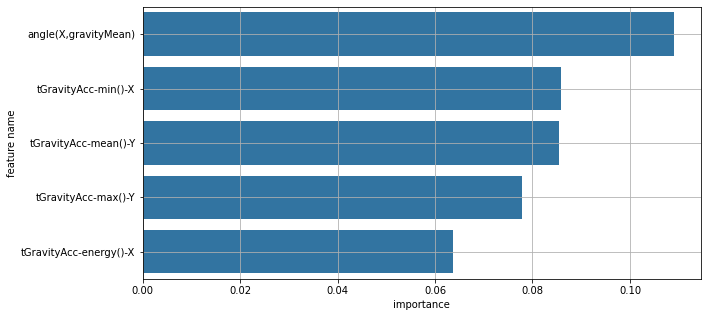

In [1585]:
plot_feature_importance(model7.feature_importances_, x_train.columns, topn=5)

In [1586]:
df7.to_csv('df_feature_imp7.csv',index=False)
df_feature_imp7=pd.read_csv('df_feature_imp7.csv')
df_feature_imp7

,feature,Importances
0,"angle(X,gravityMean)",0.109041
1,tGravityAcc-min()-X,0.085824
2,tGravityAcc-mean()-Y,0.085458
3,tGravityAcc-max()-Y,0.077796
4,tGravityAcc-energy()-X,0.063722
...,...,...
556,"tBodyAcc-arCoeff()-X,2",0.000000
557,tGravityAccMag-arCoeff()3,0.000000
558,tGravityAccMag-max(),0.000000
559,tGravityAccMag-mad(),0.000000


#### 4) feature 그룹별 분석

* 결과 merge

In [1587]:
df_feature_imp7.head()
df_feature.head()
df7 = pd.merge(df_feature_imp7, df_feature, left_on='feature', right_on='feature_name', how='inner')
df7.head()

,feature,Importances,sensor,agg,axis,feature_name
0,"angle(X,gravityMean)",0.109041,angle,X,gravityMean,"angle(X,gravityMean)"
1,tGravityAcc-min()-X,0.085824,tGravityAcc,min(),X,tGravityAcc-min()-X
2,tGravityAcc-mean()-Y,0.085458,tGravityAcc,mean(),Y,tGravityAcc-mean()-Y
3,tGravityAcc-max()-Y,0.077796,tGravityAcc,max(),Y,tGravityAcc-max()-Y
4,tGravityAcc-energy()-X,0.063722,tGravityAcc,energy(),X,tGravityAcc-energy()-X


In [1588]:
df7.drop(['feature_name'], axis=1, inplace=True)
df7.head()

,feature,Importances,sensor,agg,axis
0,"angle(X,gravityMean)",0.109041,angle,X,gravityMean
1,tGravityAcc-min()-X,0.085824,tGravityAcc,min(),X
2,tGravityAcc-mean()-Y,0.085458,tGravityAcc,mean(),Y
3,tGravityAcc-max()-Y,0.077796,tGravityAcc,max(),Y
4,tGravityAcc-energy()-X,0.063722,tGravityAcc,energy(),X


* sensor 별 중요도

In [1589]:
# sensor 별 중요도 합계
sorted_df = df7.groupby('sensor')[['Importances']].sum().sort_values(by='Importances', ascending=False)

# 상위 변수 그룹별 비교 분석
sorted_df[:10]

,Importances
sensor,
tGravityAcc,0.637391
angle,0.163506
fBodyAcc,0.031038
fBodyGyro,0.028573
tBodyAcc,0.028044
tBodyGyroJerk,0.022317
tBodyAccJerk,0.022242
tBodyGyro,0.020865
fBodyAccJerk,0.019653


* sensor + agg 별 중요도

In [1590]:
# sensor+agge별 중요도 합계
sorted_df = df7.groupby(['sensor','agg'])[['Importances']].sum().sort_values(by='Importances', ascending=False)
sorted_df[:10]

Importances
sensor      agg                       
tGravityAcc max()             0.163034
            min()             0.162104
            mean()            0.161622
            energy()          0.119243
angle       X                 0.109041
            Z                 0.039145
tBodyAcc    correlation()     0.015789
angle       Y                 0.015033
tGravityAcc correlation()     0.007389
            sma()             0.006563

### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_walking 추가

In [1591]:
df_train['Activity'].value_counts()

LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64

In [1592]:
df_train['is_walking'] = df_train['Activity'].replace({'STANDING': 0, 'SITTING': 0, 'LAYING': 0, 'WALKING': 1, 'WALKING_UPSTAIRS': 0, 'WALKING_DOWNSTAIRS': 0})
df_train['is_walking'].value_counts()

0    4883
1     998
Name: is_walking, dtype: int64

In [1593]:
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic,is_standing,is_sitting,is_laying,is_walking
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,0.072790,-0.601120,0.331298,0.165163,STANDING,0,1,0,0,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,0.771524,0.345205,-0.769186,-0.147944,LAYING,0,0,0,1,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.021528,-0.833564,0.202434,-0.032755,STANDING,0,1,0,0,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.072944,-0.695819,0.287154,0.111388,WALKING,1,0,0,0,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1,0,0,0,0


#### 2) 기본모델 생성

In [1594]:
y = df_train['is_walking']

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=1)


from sklearn.ensemble import RandomForestClassifier
model8 = RandomForestClassifier()
model8.fit(x_train, y_train)

RandomForestClassifier()

#### 3) 변수중요도 상위 5개 분석

In [1595]:
df8 = pd.DataFrame()
df8['feature'] = list(x)
df8['Importances'] = model8.feature_importances_
df8.sort_values(by = 'Importances', ascending=False, inplace=True)
df8[:5]



,feature,Importances
37,"tBodyAcc-correlation()-X,Y",0.033209
503,fBodyAccMag-std(),0.023786
65,"tGravityAcc-arCoeff()-X,1",0.023390
504,fBodyAccMag-mad(),0.020669
67,"tGravityAcc-arCoeff()-X,3",0.018754


* 상위 변수 선정

In [1596]:
cols=list(df8.iloc[:5,:1]['feature'])
cols

['tBodyAcc-correlation()-X,Y',
 'fBodyAccMag-std()',
 'tGravityAcc-arCoeff()-X,1',
 'fBodyAccMag-mad()',
 'tGravityAcc-arCoeff()-X,3']

* 데이터 탐색하기

,feature_name,feature_importance
0,"tBodyAcc-correlation()-X,Y",0.033209
1,fBodyAccMag-std(),0.023786
2,"tGravityAcc-arCoeff()-X,1",0.023390
3,fBodyAccMag-mad(),0.020669
4,"tGravityAcc-arCoeff()-X,3",0.018754


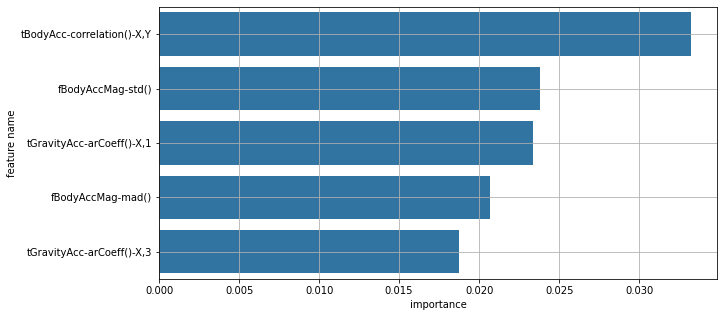

In [1597]:
plot_feature_importance(model8.feature_importances_, x_train.columns, topn=5)

In [1598]:
df8.to_csv('df_feature_imp8.csv',index=False)
df_feature_imp8=pd.read_csv('df_feature_imp8.csv')
df_feature_imp8

,feature,Importances
0,"tBodyAcc-correlation()-X,Y",0.033209
1,fBodyAccMag-std(),0.023786
2,"tGravityAcc-arCoeff()-X,1",0.023390
3,fBodyAccMag-mad(),0.020669
4,"tGravityAcc-arCoeff()-X,3",0.018754
...,...,...
556,"fBodyAcc-bandsEnergy()-57,64.2",0.000016
557,"tBodyGyroJerk-arCoeff()-X,2",0.000008
558,fBodyAcc-mad()-Y,0.000008
559,fBodyAccJerk-iqr()-X,0.000005


#### 4) feature 그룹별 분석

* 결과 merge

In [1599]:
df_feature_imp8.head()
df_feature.head()
df8 = pd.merge(df_feature_imp8, df_feature, left_on='feature', right_on='feature_name', how='inner')
df8.head()

,feature,Importances,sensor,agg,axis,feature_name
0,"tBodyAcc-correlation()-X,Y",0.033209,tBodyAcc,correlation(),"X,Y","tBodyAcc-correlation()-X,Y"
1,fBodyAccMag-std(),0.023786,fBodyAccMag,std(),NaN,fBodyAccMag-std()
2,"tGravityAcc-arCoeff()-X,1",0.023390,tGravityAcc,arCoeff(),"X,1","tGravityAcc-arCoeff()-X,1"
3,fBodyAccMag-mad(),0.020669,fBodyAccMag,mad(),NaN,fBodyAccMag-mad()
4,"tGravityAcc-arCoeff()-X,3",0.018754,tGravityAcc,arCoeff(),"X,3","tGravityAcc-arCoeff()-X,3"


In [1600]:
df8.drop(['feature_name'], axis=1, inplace=True)
df8.head()

,feature,Importances,sensor,agg,axis
0,"tBodyAcc-correlation()-X,Y",0.033209,tBodyAcc,correlation(),"X,Y"
1,fBodyAccMag-std(),0.023786,fBodyAccMag,std(),NaN
2,"tGravityAcc-arCoeff()-X,1",0.023390,tGravityAcc,arCoeff(),"X,1"
3,fBodyAccMag-mad(),0.020669,fBodyAccMag,mad(),NaN
4,"tGravityAcc-arCoeff()-X,3",0.018754,tGravityAcc,arCoeff(),"X,3"


* sensor 별 중요도

In [1601]:
# sensor 별 중요도 합계
sorted_df = df8.groupby('sensor')[['Importances']].sum().sort_values(by='Importances', ascending=False)

# 상위 변수 그룹별 비교 분석
sorted_df[:10]

,Importances
sensor,
tGravityAcc,0.137854
fBodyAccJerk,0.127990
fBodyAcc,0.127375
fBodyGyro,0.114219
tBodyGyroJerk,0.089916
fBodyAccMag,0.081262
tBodyAcc,0.075926
tBodyAccJerk,0.075338
tGravityAccMag,0.066547


* sensor + agg 별 중요도

In [1602]:
# sensor+agge별 중요도 합계
sorted_df = df8.groupby(['sensor','agg'])[['Importances']].sum().sort_values(by='Importances', ascending=False)
sorted_df[:10]

,,Importances
sensor,agg,
tGravityAcc,arCoeff(),0.100115
fBodyGyro,bandsEnergy(),0.081381
fBodyAcc,bandsEnergy(),0.076258
fBodyAccJerk,bandsEnergy(),0.064591
tBodyAcc,correlation(),0.034436
fBodyAccMag,std(),0.023786
tBodyGyroJerk,std(),0.022288
fBodyGyro,maxInds,0.021273
fBodyAccMag,mad(),0.020669


### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_walking_up 추가

In [1603]:
df_train['Activity'].value_counts()

LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64

In [1604]:
df_train['is_walking_up'] = df_train['Activity'].replace({'STANDING': 1, 'SITTING': 0, 'LAYING': 0, 'WALKING': 0, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 0})
df_train['is_walking_up'].value_counts()

0    3936
1    1945
Name: is_walking_up, dtype: int64

In [1605]:
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic,is_standing,is_sitting,is_laying,is_walking,is_walking_up
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.601120,0.331298,0.165163,STANDING,0,1,0,0,0,1
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,0.345205,-0.769186,-0.147944,LAYING,0,0,0,1,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.833564,0.202434,-0.032755,STANDING,0,1,0,0,0,1
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.695819,0.287154,0.111388,WALKING,1,0,0,0,1,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1,0,0,0,0,0


#### 2) 기본모델 생성

In [1606]:
y = df_train['is_walking_up']

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=1)


from sklearn.ensemble import RandomForestClassifier
model9 = RandomForestClassifier()
model9.fit(x_train, y_train)

RandomForestClassifier()

#### 3) 변수중요도 상위 5개 분석

In [1607]:
df9 = pd.DataFrame()
df9['feature'] = list(x)
df9['Importances'] = model9.feature_importances_
df9.sort_values(by = 'Importances', ascending=False, inplace=True)
df9[:5]

,feature,Importances
50,tGravityAcc-max()-Y,0.063916
41,tGravityAcc-mean()-Y,0.045459
53,tGravityAcc-min()-Y,0.039916
559,"angle(Y,gravityMean)",0.031871
57,tGravityAcc-energy()-Y,0.021101


* 상위 변수 선정

In [1608]:
cols=list(df9.iloc[:5,:1]['feature'])
cols

['tGravityAcc-max()-Y',
 'tGravityAcc-mean()-Y',
 'tGravityAcc-min()-Y',
 'angle(Y,gravityMean)',
 'tGravityAcc-energy()-Y']

* 데이터 탐색하기

,feature_name,feature_importance
0,tGravityAcc-max()-Y,0.063916
1,tGravityAcc-mean()-Y,0.045459
2,tGravityAcc-min()-Y,0.039916
3,"angle(Y,gravityMean)",0.031871
4,tGravityAcc-energy()-Y,0.021101


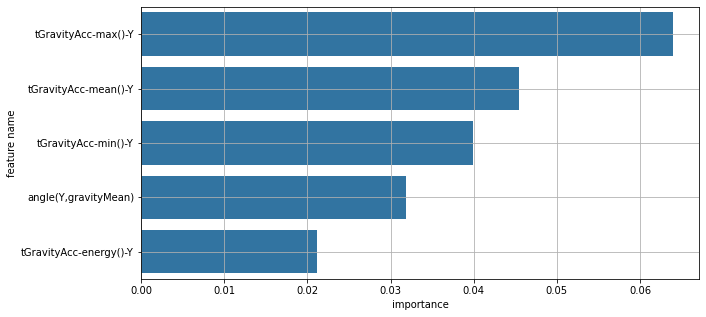

In [1609]:
plot_feature_importance(model9.feature_importances_, x_train.columns, topn=5)

In [1610]:
df9.to_csv('df_feature_imp9.csv',index=False)
df_feature_imp9=pd.read_csv('df_feature_imp9.csv')
df_feature_imp9

,feature,Importances
0,tGravityAcc-max()-Y,0.063916
1,tGravityAcc-mean()-Y,0.045459
2,tGravityAcc-min()-Y,0.039916
3,"angle(Y,gravityMean)",0.031871
4,tGravityAcc-energy()-Y,0.021101
...,...,...
556,"fBodyAccJerk-bandsEnergy()-57,64.2",0.000128
557,tBodyGyroJerk-min()-Y,0.000104
558,"fBodyGyro-bandsEnergy()-49,56.1",0.000103
559,"tBodyAccJerk-arCoeff()-Y,3",0.000100


#### 4) feature 그룹별 분석

* 결과 merge

In [1611]:
df_feature_imp9.head()
df_feature.head()
df9 = pd.merge(df_feature_imp9, df_feature, left_on='feature', right_on='feature_name', how='inner')
df9.head()

,feature,Importances,sensor,agg,axis,feature_name
0,tGravityAcc-max()-Y,0.063916,tGravityAcc,max(),Y,tGravityAcc-max()-Y
1,tGravityAcc-mean()-Y,0.045459,tGravityAcc,mean(),Y,tGravityAcc-mean()-Y
2,tGravityAcc-min()-Y,0.039916,tGravityAcc,min(),Y,tGravityAcc-min()-Y
3,"angle(Y,gravityMean)",0.031871,angle,Y,gravityMean,"angle(Y,gravityMean)"
4,tGravityAcc-energy()-Y,0.021101,tGravityAcc,energy(),Y,tGravityAcc-energy()-Y


In [1612]:
df9.drop(['feature_name'], axis=1, inplace=True)
df9.head()

,feature,Importances,sensor,agg,axis
0,tGravityAcc-max()-Y,0.063916,tGravityAcc,max(),Y
1,tGravityAcc-mean()-Y,0.045459,tGravityAcc,mean(),Y
2,tGravityAcc-min()-Y,0.039916,tGravityAcc,min(),Y
3,"angle(Y,gravityMean)",0.031871,angle,Y,gravityMean
4,tGravityAcc-energy()-Y,0.021101,tGravityAcc,energy(),Y


* sensor 별 중요도

In [1613]:
# sensor 별 중요도 합계
sorted_df = df9.groupby('sensor')[['Importances']].sum().sort_values(by='Importances', ascending=False)

# 상위 변수 그룹별 비교 분석
sorted_df[:10]

,Importances
sensor,
tGravityAcc,0.393807
fBodyAccJerk,0.091561
fBodyGyro,0.087277
fBodyAcc,0.086145
angle,0.066196
tBodyGyroJerk,0.047112
tBodyGyro,0.045334
tBodyAccJerkMag,0.034145
tBodyAccJerk,0.033458


* sensor + agg 별 중요도

In [1614]:
# sensor+agge별 중요도 합계
sorted_df = df9.groupby(['sensor','agg'])[['Importances']].sum().sort_values(by='Importances', ascending=False)
sorted_df[:10]

Importances
sensor       agg                       
tGravityAcc  max()             0.093052
             arCoeff()         0.081855
             min()             0.068601
             mean()            0.067582
             energy()          0.048103
fBodyAccJerk bandsEnergy()     0.047423
fBodyAcc     bandsEnergy()     0.047131
fBodyGyro    bandsEnergy()     0.038121
angle        Y                 0.031871
             Z                 0.019889

### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_walking_down 추가

In [1615]:
df_train['Activity'].value_counts()

LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64

In [1616]:
df_train['is_waling_down'] = df_train['Activity'].replace({'STANDING': 0, 'SITTING': 0, 'LAYING': 0, 'WALKING': 0, 'WALKING_UPSTAIRS': 0, 'WALKING_DOWNSTAIRS': 1})
df_train['is_waling_down'].value_counts()

0    5090
1     791
Name: is_waling_down, dtype: int64

In [1617]:
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic,is_standing,is_sitting,is_laying,is_walking,is_walking_up,is_waling_down
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,0.331298,0.165163,STANDING,0,1,0,0,0,1,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.769186,-0.147944,LAYING,0,0,0,1,0,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.202434,-0.032755,STANDING,0,1,0,0,0,1,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.287154,0.111388,WALKING,1,0,0,0,1,0,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,0.264952,0.137758,WALKING_DOWNSTAIRS,1,0,0,0,0,0,1


#### 2) 기본모델 생성

In [1618]:
y = df_train['is_waling_down']

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=1)


from sklearn.ensemble import RandomForestClassifier
model10 = RandomForestClassifier()
model10.fit(x_train, y_train)

RandomForestClassifier()

#### 3) 변수중요도 상위 5개 분석

In [1619]:
df10 = pd.DataFrame()
df10['feature'] = list(x)
df10['Importances'] = model10.feature_importances_
df10.sort_values(by = 'Importances', ascending=False, inplace=True)
df10[:5]

,feature,Importances
504,fBodyAccMag-mad(),0.045067
215,tGravityAccMag-mad(),0.042512
271,fBodyAcc-mad()-X,0.038220
202,tBodyAccMag-mad(),0.036642
502,fBodyAccMag-mean(),0.034656


* 상위 변수 선정

In [1620]:
cols=list(df10.iloc[:5,:1]['feature'])
cols

['fBodyAccMag-mad()',
 'tGravityAccMag-mad()',
 'fBodyAcc-mad()-X',
 'tBodyAccMag-mad()',
 'fBodyAccMag-mean()']

* 데이터 탐색하기

,feature_name,feature_importance
0,fBodyAccMag-mad(),0.045067
1,tGravityAccMag-mad(),0.042512
2,fBodyAcc-mad()-X,0.038220
3,tBodyAccMag-mad(),0.036642
4,fBodyAccMag-mean(),0.034656


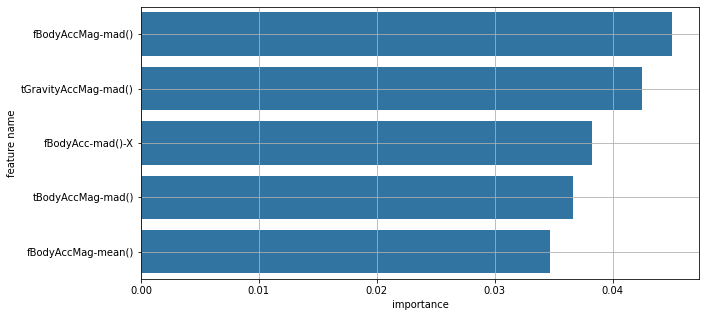

In [1621]:
plot_feature_importance(model10.feature_importances_, x_train.columns, topn=5)

In [1622]:
df10.to_csv('df_feature_imp10.csv',index=False)
df_feature_imp10=pd.read_csv('df_feature_imp10.csv')
df_feature_imp10

,feature,Importances
0,fBodyAccMag-mad(),0.045067
1,tGravityAccMag-mad(),0.042512
2,fBodyAcc-mad()-X,0.038220
3,tBodyAccMag-mad(),0.036642
4,fBodyAccMag-mean(),0.034656
...,...,...
556,fBodyAcc-entropy()-Y,0.000014
557,"tBodyAccJerk-arCoeff()-Y,1",0.000012
558,"tBodyGyro-arCoeff()-Z,3",0.000011
559,fBodyAcc-maxInds-Z,0.000000


#### 4) feature 그룹별 분석

* 결과 merge

In [1623]:
df_feature_imp10.head()
df_feature.head()
df10 = pd.merge(df_feature_imp10, df_feature, left_on='feature', right_on='feature_name', how='inner')
df10.head()

,feature,Importances,sensor,agg,axis,feature_name
0,fBodyAccMag-mad(),0.045067,fBodyAccMag,mad(),NaN,fBodyAccMag-mad()
1,tGravityAccMag-mad(),0.042512,tGravityAccMag,mad(),NaN,tGravityAccMag-mad()
2,fBodyAcc-mad()-X,0.038220,fBodyAcc,mad(),X,fBodyAcc-mad()-X
3,tBodyAccMag-mad(),0.036642,tBodyAccMag,mad(),NaN,tBodyAccMag-mad()
4,fBodyAccMag-mean(),0.034656,fBodyAccMag,mean(),NaN,fBodyAccMag-mean()


In [1624]:
df10.drop(['feature_name'], axis=1, inplace=True)
df10.head()

,feature,Importances,sensor,agg,axis
0,fBodyAccMag-mad(),0.045067,fBodyAccMag,mad(),NaN
1,tGravityAccMag-mad(),0.042512,tGravityAccMag,mad(),NaN
2,fBodyAcc-mad()-X,0.038220,fBodyAcc,mad(),X
3,tBodyAccMag-mad(),0.036642,tBodyAccMag,mad(),NaN
4,fBodyAccMag-mean(),0.034656,fBodyAccMag,mean(),NaN


* sensor 별 중요도

In [1625]:
# sensor 별 중요도 합계
sorted_df = df10.groupby('sensor')[['Importances']].sum().sort_values(by='Importances', ascending=False)

# 상위 변수 그룹별 비교 분석
sorted_df[:10]

,Importances
sensor,
fBodyAcc,0.193609
fBodyAccMag,0.175918
tBodyAccMag,0.135072
tGravityAccMag,0.100168
tBodyAcc,0.096988
fBodyAccJerk,0.069679
tGravityAcc,0.048022
tBodyAccJerk,0.045903
fBodyGyro,0.045765


* sensor + agg 별 중요도

In [1626]:
# sensor+agge별 중요도 합계
sorted_df = df10.groupby(['sensor','agg'])[['Importances']].sum().sort_values(by='Importances', ascending=False)
sorted_df[:10]

,,Importances
sensor,agg,
fBodyAcc,bandsEnergy(),0.063050
fBodyAccMag,mad(),0.045067
tGravityAccMag,mad(),0.042512
fBodyAccJerk,bandsEnergy(),0.042169
fBodyAcc,mad(),0.038759
tBodyAccMag,mad(),0.036642
fBodyAccMag,mean(),0.034656
tGravityAccMag,std(),0.031023
fBodyAccMag,sma(),0.030203


## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

In [1627]:
df_feature_imp=pd.read_csv('df_feature_imp.csv')
df_feature_imp4=pd.read_csv('df_feature_imp4.csv')
df_feature_imp5=pd.read_csv('df_feature_imp5.csv')
df_feature_imp6=pd.read_csv('df_feature_imp6.csv')
df_feature_imp7=pd.read_csv('df_feature_imp7.csv')
df_feature_imp8=pd.read_csv('df_feature_imp8.csv')
df_feature_imp9=pd.read_csv('df_feature_imp9.csv')
df_feature_imp10=pd.read_csv('df_feature_imp10.csv')

In [1628]:
cols=['df_feature_imp', 'df_feature_imp4', 'df_feature_imp5', 'df_feature_imp6', 'df_feature_imp7', 'df_feature_imp8', 'df_feature_imp9', 'df_feature_imp10']
cols

['df_feature_imp',
 'df_feature_imp4',
 'df_feature_imp5',
 'df_feature_imp6',
 'df_feature_imp7',
 'df_feature_imp8',
 'df_feature_imp9',
 'df_feature_imp10']

#### 1) 이름변경

In [1629]:
#! 이름변경 imp_activity
df_feature_imp.rename(columns={'Importances':'imp'},inplace=True)
df_feature_imp4.rename(columns={'Importances':'imp4'},inplace=True)
df_feature_imp5.rename(columns={'Importances':'imp5'},inplace=True)
df_feature_imp6.rename(columns={'Importances':'imp6'},inplace=True)
df_feature_imp7.rename(columns={'Importances':'imp7'},inplace=True)
df_feature_imp8.rename(columns={'Importances':'imp8'},inplace=True)
df_feature_imp9.rename(columns={'Importances':'imp9'},inplace=True)
df_feature_imp10.rename(columns={'Importances':'imp10'},inplace=True)
df_feature_imp10

,feature,imp10
0,fBodyAccMag-mad(),0.045067
1,tGravityAccMag-mad(),0.042512
2,fBodyAcc-mad()-X,0.038220
3,tBodyAccMag-mad(),0.036642
4,fBodyAccMag-mean(),0.034656
...,...,...
556,fBodyAcc-entropy()-Y,0.000014
557,"tBodyAccJerk-arCoeff()-Y,1",0.000012
558,"tBodyGyro-arCoeff()-Z,3",0.000011
559,fBodyAcc-maxInds-Z,0.000000


#### 2) 합치기

In [1630]:
df_feature

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y
...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)"
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)"
558,angle,X,gravityMean,"angle(X,gravityMean)"
559,angle,Y,gravityMean,"angle(Y,gravityMean)"


In [1631]:
df11 = pd.merge(df_feature, df_feature_imp, left_on='feature_name', right_on='feature', how='inner')
df11.drop(['feature_name'], axis=1, inplace=True)
df11

,sensor,agg,axis,feature,imp
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000293
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000373
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000242
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.006984
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000276
...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000488
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000448
558,angle,X,gravityMean,"angle(X,gravityMean)",0.024073
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.033649


In [1632]:
result = pd.merge(df11, df_feature_imp4, on='feature', how='inner')
result = pd.merge(result, df_feature_imp5, on='feature', how='inner')
result = pd.merge(result, df_feature_imp6, on='feature', how='inner')
result = pd.merge(result, df_feature_imp7, on='feature', how='inner')
result = pd.merge(result, df_feature_imp8, on='feature', how='inner')
result = pd.merge(result, df_feature_imp9, on='feature', how='inner')
result = pd.merge(result, df_feature_imp10, on='feature', how='inner')
df18

,sensor,agg,axis,feature,imp,imp4,imp5,imp6,imp7,imp8,imp9,imp10
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000283,0.000000,0.000237,0.000355,0.000103,0.000047,0.000226,0.000144
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000375,0.000000,0.000373,0.000802,0.000071,0.000027,0.000942,0.000213
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000169,0.000000,0.000356,0.000348,0.000031,0.000099,0.000664,0.000155
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.006005,0.000019,0.004929,0.000873,0.000574,0.010405,0.001171,0.008771
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000350,0.000000,0.000076,0.000618,0.000024,0.000304,0.000462,0.000652
...,...,...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000544,0.000000,0.000717,0.001150,0.000015,0.000328,0.000879,0.000578
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000576,0.000000,0.003163,0.001425,0.000027,0.000166,0.000844,0.000051
558,angle,X,gravityMean,"angle(X,gravityMean)",0.026346,0.000020,0.018236,0.028717,0.116251,0.002866,0.020683,0.001292
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.023692,0.000010,0.055001,0.066231,0.051360,0.002967,0.039096,0.002277


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
import joblib

In [1633]:
#! 추가
# df18.to_csv('df_feature_imp_total.pkl',index=False)

df18.to_csv('df_feature_imp_total.csv',index=False)
df_feature_imp_total=pd.read_csv('df_feature_imp_total.csv')
df_feature_imp_total

,sensor,agg,axis,feature,imp,imp4,imp5,imp6,imp7,imp8,imp9,imp10
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000283,0.000000,0.000237,0.000355,0.000103,0.000047,0.000226,0.000144
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000375,0.000000,0.000373,0.000802,0.000071,0.000027,0.000942,0.000213
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000169,0.000000,0.000356,0.000348,0.000031,0.000099,0.000664,0.000155
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.006005,0.000019,0.004929,0.000873,0.000574,0.010405,0.001171,0.008771
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000350,0.000000,0.000076,0.000618,0.000024,0.000304,0.000462,0.000652
...,...,...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000544,0.000000,0.000717,0.001150,0.000015,0.000328,0.000879,0.000578
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000576,0.000000,0.003163,0.001425,0.000027,0.000166,0.000844,0.000051
558,angle,X,gravityMean,"angle(X,gravityMean)",0.026346,0.000020,0.018236,0.028717,0.116251,0.002866,0.020683,0.001292
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.023692,0.000010,0.055001,0.066231,0.051360,0.002967,0.039096,0.002277
